In [1]:
import os
import imp
setting = imp.load_source('setting', 'C:/Users/Azure/Documents/Projects/Zhizhu_Google_Ads_System/settings.py')

import pandas as pd
import numpy as np

from sklearn import preprocessing
from statsmodels.formula.api import ols

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
d29 = pd.read_hdf(os.path.join(setting.PROCESSED_DIR, 'GooAds.h5'), 'daily/29_2')

In [3]:
d29.head()

,TMatch,Catch,Day,Campaign_ID,Campaign,Campaign_state,Account,Account_ID,Budget,OS,...,Display_Network,Search_Network,YouTube_Search,YouTube_Videos,CTR,adwCVR,adwCPI,Lefty,Profit,Gaps
0,20170728-833717216,2017-07-29,2017-07-28,833717216,GY-BUT0517-IQ-009-0522,enabled,Bigo-dvi-r-adr-05-gy,2085910468,50,adr,...,0.000,0.000,None,0.000,0.000,0.000,0.000,50.000,0.000,1
1,20170728-833717270,2017-07-29,2017-07-28,833717270,GY-BUT0517-ID-040-0522,enabled,Bigo-dvi-r-adr-05-gy,2085910468,50,adr,...,0.000,0.000,None,0.400,0.004,0.500,0.400,49.600,0.020,1
2,20170728-833717276,2017-07-29,2017-07-28,833717276,GY-BUT0517-VN-038-0522,enabled,Bigo-dvi-r-adr-05-gy,2085910468,50,adr,...,5.730,0.000,None,0.130,0.006,0.049,0.450,44.140,-0.660,1
3,20170728-833717279,2017-07-29,2017-07-28,833717279,GY-BUT0517-SA-038-0522,enabled,Bigo-dvi-r-adr-05-gy,2085910468,50,adr,...,0.030,0.000,None,1.400,0.013,0.400,0.720,48.570,-0.630,1
4,20170728-833717426,2017-07-29,2017-07-28,833717426,GY-BUT0517-MY-048-0522,enabled,Bigo-dvi-r-adr-05-gy,2085910468,50,adr,...,0.040,0.000,None,0.090,0.015,0.000,0.000,49.870,-0.130,1


In [4]:
d29 = d29.reset_index().drop('index', axis=1)

In [5]:
# 加入转化率的 Z 分数归一化列
d29 = \
d29.join(
pd.Series(
preprocessing.StandardScaler().fit(d29['Conversions'].astype('float64').reshape(-1,1))\
.transform(d29['Conversions'].astype('float64').reshape(-1,1))[:, 0], name='ConvStd'))

In [6]:
# 加入转化率根据最大最小值归一化的列
d29 = \
d29.join(
pd.Series(
preprocessing.MinMaxScaler().fit(d29['Conversions'].astype('float64').reshape(-1,1))\
.transform(d29['Conversions'].astype('float64').reshape(-1,1))[:, 0], name='ConvMM'))

In [ ]:
d29[d29]

# 准备数据

In [7]:
selected_cols = ['Campaign_ID', 'Campaign', 'Campaign_state',
                 'Catch', 'Day', 'Gaps',
                 'Budget', 'OS', 'Geo', 'Type',
                 'Conversions', 'ConvStd', 'ConvMM',
                 'Cost', 'Display_Network', 'Search_Network', 'YouTube_Search', 'YouTube_Videos']

In [8]:
ads = d29[selected_cols]

# 检查数据完整性

In [9]:
def count_days(x):
    return x.groupby('Day').Catch.count()

In [10]:
ads[(ads.Campaign_ID == '864161415') | (ads.Campaign_ID == '847447161') | (ads.Campaign_ID == '864151905')]\
.groupby('Campaign_ID').apply(count_days).stack()

Campaign_ID  Day       
847447161    2017-07-28    14
             2017-07-29    13
             2017-07-30    13
             2017-07-31    12
             2017-08-01    12
             2017-08-02    11
             2017-08-03    10
             2017-08-04     9
             2017-08-05     9
             2017-08-06     9
             2017-08-07     9
             2017-08-08     9
             2017-08-09     8
             2017-08-10     7
             2017-08-11     6
             2017-08-12     5
             2017-08-13     5
             2017-08-14     4
             2017-08-15     3
             2017-08-16     3
             2017-08-17     2
             2017-08-18     1
             2017-08-19     1
             2017-08-20     1
864151905    2017-07-28    14
             2017-07-29    13
             2017-07-30    13
             2017-07-31    12
             2017-08-01    12
             2017-08-02    11
                           ..
             2017-08-15     3
             201

In [11]:
ads.groupby('Campaign_ID').apply(count_days)

Campaign_ID  Day       
816264229    2017-07-28    15
             2017-07-29    15
             2017-07-30    14
             2017-07-31    13
             2017-08-01    13
             2017-08-02    12
             2017-08-03    11
             2017-08-04    10
             2017-08-05    10
             2017-08-06    10
             2017-08-07     9
             2017-08-08     9
             2017-08-09     8
             2017-08-10     7
816270400    2017-07-28    15
             2017-07-29    15
             2017-07-30    14
             2017-07-31    13
             2017-08-01    13
             2017-08-02    12
             2017-08-03    11
             2017-08-04    10
             2017-08-05    10
             2017-08-06    10
             2017-08-07     9
             2017-08-08     9
             2017-08-09     8
             2017-08-10     7
816272578    2017-07-28    15
             2017-07-29    15
                           ..
911529501    2017-08-20     1
911533608    201

- 大部分项目 7.28 和 7.29 两天都有 15 天的回溯数据了。由于数据点较为充足，因此前 5 天应该拟合的都可以比较稳定。

In [12]:
ads.groupby('Campaign_ID').Catch.count().describe()

count   3888.000
mean     109.827
std       69.812
min        1.000
25%       38.000
50%      124.000
75%      176.000
max      188.000
Name: Catch, dtype: float64

In [13]:
# 筛选掉一半的（回溯天数不足的）项目
ads = \
ads[ads.Campaign_ID.isin(
    ads.groupby('Campaign_ID').Catch.count()[ads.groupby('Campaign_ID').Catch.count() > ads.groupby('Campaign_ID').Catch.count().median()].index
)]

# 核心算法

In [14]:
def fitting_linear_regression(x):
    if x.Cost.mean() < 10:
        pass #死鱼没人权
    else:
        x = x[x.Day <= x.sort_values('Day').Day.unique()[4]] #每个项目只看前 5 天的数据
        return x.groupby('Day').apply(fit_lr)

In [15]:
def fit_lr(x):
    fitted = ols('ConvStd ~ Gaps', data=x).fit() #拟合回归模型
    parameter = pd.concat([pd.Series(fitted.params, name='params'),
                           pd.Series(fitted.pvalues, name='pvalues')], axis=1).stack() #获得截距项及斜率，以及对应的 p 值
    
    # 把截距项、斜率（及其对应的 p 值）、R 平方等数据整理成合适的数据形式再返回
    values = \
    pd.Series(parameter.values, index=[i[0]+i[1] for i in parameter.index.tolist()], name='values')\
    .append(pd.Series(fitted.rsquared, index=['rsquared'], name='values'))\
    .append(pd.Series(fitted.rsquared_adj, index=['rsquared_adj'], name='values'))
    
    return pd.DataFrame(values).T

# 测试

In [28]:
ads[(ads.Campaign_ID == '864161415')]

,Campaign_ID,Campaign,Campaign_state,Catch,Day,Gaps,Budget,OS,Geo,Type,Conversions,ConvStd,ConvMM,Cost,Display_Network,Search_Network,YouTube_Search,YouTube_Videos
2116,864161415,GB-ETN0622b-VN-042-0622,enabled,2017-07-29,2017-07-28,1,300,adr,VN,GB,721,12.983,0.453,308.800,308.800,0.000,None,0.000
6726,864161415,GB-ETN0622b-VN-042-0622,enabled,2017-07-31,2017-07-28,3,400,adr,VN,GB,800,14.426,0.503,308.690,308.690,0.000,None,0.000
6738,864161415,GB-ETN0622b-VN-042-0622,enabled,2017-07-31,2017-07-29,2,400,adr,VN,GB,808,14.572,0.508,361.240,361.240,0.000,None,0.000
6750,864161415,GB-ETN0622b-VN-042-0622,enabled,2017-07-31,2017-07-30,1,400,adr,VN,GB,655,11.778,0.412,293.240,293.240,0.000,None,0.000
14115,864161415,GB-ETN0622b-VN-042-0622,enabled,2017-08-01,2017-07-28,4,400,adr,VN,GB,828,14.937,0.520,308.690,308.690,0.000,None,0.000
14127,864161415,GB-ETN0622b-VN-042-0622,enabled,2017-08-01,2017-07-29,3,400,adr,VN,GB,849,15.321,0.534,361.240,361.240,0.000,None,0.000
14139,864161415,GB-ETN0622b-VN-042-0622,enabled,2017-08-01,2017-07-30,2,400,adr,VN,GB,708,12.746,0.445,293.230,293.230,0.000,None,0.000
14151,864161415,GB-ETN0622b-VN-042-0622,enabled,2017-08-01,2017-07-31,1,400,adr,VN,GB,719,12.947,0.452,367.010,366.870,0.140,None,0.000
23552,864161415,GB-ETN0622b-VN-042-0622,enabled,2017-08-02,2017-07-28,5,400,adr,VN,GB,856,15.449,0.538,308.690,308.690,0.000,None,0.000
23564,864161415,GB-ETN0622b-VN-042-0622,enabled,2017-08-02,2017-07-29,4,400,adr,VN,GB,875,15.796,0.550,361.240,361.240,0.000,None,0.000


In [16]:
ads[(ads.Campaign_ID == '864161415') | (ads.Campaign_ID == '847447161') | (ads.Campaign_ID == '864151905')]\
.groupby('Campaign_ID').apply(fitting_linear_regression)

Interceptparams  Interceptpvalues  Gapsparams  \
Campaign_ID Day                                                                
847447161   2017-07-28 values            9.379             0.000       0.029   
            2017-07-29 values            9.340             0.000       0.029   
            2017-07-30 values           10.423             0.000       0.048   
            2017-07-31 values           17.018             0.000       0.059   
            2017-08-01 values           23.097             0.000       0.071   
864151905   2017-07-28 values            6.846             0.000       0.205   
            2017-07-29 values            7.917             0.000       0.248   
            2017-07-30 values           12.011             0.000       0.330   
            2017-07-31 values            8.340             0.000       0.289   
            2017-08-01 values            9.310             0.000       0.310   
864161415   2017-07-28 values           13.815             0.000       0.269   
            2017-07-29 values           14.518             0.000       0.308   
            2017-07-30 values           12.394             0.000       0.312   
            2017-07-31 values           13.431             0.000       0.350   
            2017-08-01 values           16.229             0.000       0.401   

                               Gapspvalues  rsquared  rsquared_adj  
Campaign_ID Day                                                     
847447161   2017-07-28 values        0.000     0.921         0.915  
            2017-07-29 values        0.000     0.977         0.975  
            2017-07-30 values        0.000     0.933         0.926  
            2017-07-31 values        0.000     0.928         0.921  
            2017-08-01 values        0.000     0.888         0.877  
864151905   2017-07-28 values        0.000     0.978         0.976  
            2017-07-29 values        0.000     0.986         0.985  
            2017-07-30 values        0.000     0.975         0.973  
            2017-07-31 values        0.000     0.966         0.963  
            2017-08-01 values        0.000     0.967         0.963  
864161415   2017-07-28 values        0.000     0.947         0.943  
            2017-07-29 values        0.000     0.984         0.982  
            2017-07-30 values        0.000     0.955         0.951  
            2017-07-31 values        0.000     0.961         0.957  
            2017-08-01 values        0.000     0.956         0.952

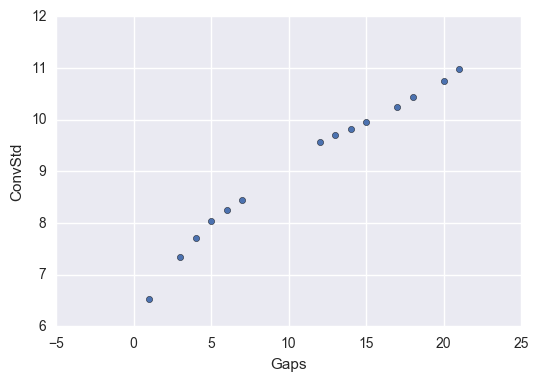

In [17]:
d29[d29.Campaign_ID == '864151905'].groupby('Day').get_group('2017-07-28').plot.scatter('Gaps', 'ConvStd');

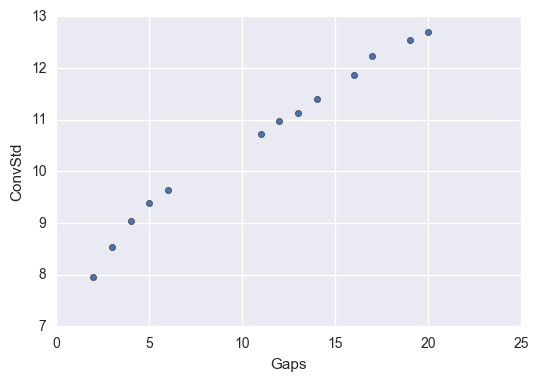

In [18]:
d29[d29.Campaign_ID == '864151905'].groupby('Day').get_group('2017-07-29').plot.scatter('Gaps', 'ConvStd');

# 主测试

In [19]:
test = ads.groupby('Campaign_ID').apply(fitting_linear_regression)

In [20]:
test = test.replace([np.inf, -np.inf], 0)

In [21]:
test2 = \
test[test.rsquared > 0.7].reset_index().drop('level_2', axis=1)\
.groupby('Campaign_ID').mean()\
.join(ads[['Campaign_ID', 'OS', 'Geo', 'Type']].drop_duplicates().set_index('Campaign_ID'))

test2.head()

,Interceptparams,Interceptpvalues,Gapsparams,Gapspvalues,rsquared,rsquared_adj,OS,Geo,Type
Campaign_ID,,,,,,,,,
819439340,0.076,0.323,0.046,0.000,0.955,0.951,adr,SA,YT
823302188,-0.056,0.329,0.024,0.000,0.913,0.905,adr,MY,YT
823421263,1.664,0.000,0.139,0.000,0.954,0.950,adr,ID,YT
823906297,2.693,0.000,0.171,0.000,0.941,0.936,adr,VN,GY
824386052,0.557,0.000,0.008,0.000,0.834,0.820,adr,VN,GB


In [23]:
test2.groupby('OS')['Interceptparams', 'Gapsparams'].mean()

,Interceptparams,Gapsparams
OS,,
adr,1.525,0.035
ios,0.294,0.014


In [24]:
test2.groupby('Type')['Interceptparams', 'Gapsparams'].mean()

,Interceptparams,Gapsparams
Type,,
BN,0.596,0.031
GB,1.245,0.029
GY,0.848,0.018
PP,3.465,0.011
VD,0.742,0.007
YT,0.947,0.076


In [25]:
test2.groupby('Geo')['Interceptparams', 'Gapsparams'].mean()

,Interceptparams,Gapsparams
Geo,,
AU,0.020,0.002
BR,0.034,0.003
CA,-0.045,0.003
HK,-0.058,0.001
ID,2.642,0.061
IN,2.857,0.048
IQ,2.919,0.036
JP,0.160,0.003
KR,0.322,0.004


In [30]:
pd.pivot_table(data=test2, values='Interceptparams', columns='OS', index='Geo', aggfunc='mean')

OS,adr,ios
Geo,,
AU,nan,0.020
BR,nan,0.034
CA,-0.030,-0.059
HK,nan,-0.058
ID,2.642,nan
IN,3.827,0.674
IQ,4.791,0.422
JP,0.233,0.015
KR,nan,0.322


In [31]:
pd.pivot_table(data=test2, values='Interceptparams', columns='OS', index='Type', aggfunc='mean')

OS,adr,ios
Type,,
BN,0.596,nan
GB,1.532,0.315
GY,1.017,0.175
PP,3.465,nan
VD,0.742,nan
YT,1.256,0.269


In [27]:
test2[test2.Interceptparams < 0]

,Interceptparams,Interceptpvalues,Gapsparams,Gapspvalues,rsquared,rsquared_adj,OS,Geo,Type
Campaign_ID,,,,,,,,,
823302188,-0.056,0.329,0.024,0.000,0.913,0.905,adr,MY,YT
828372451,-0.021,0.000,0.001,0.000,0.761,0.739,adr,US,PP
829345663,-0.139,0.000,0.004,0.000,0.820,0.803,adr,VN,GB
829612009,-0.179,0.000,0.001,0.000,0.745,0.723,adr,VN,GB
830158205,-0.074,0.000,0.001,0.060,0.815,0.800,adr,TH,GB
830225486,-0.099,0.000,0.003,0.000,0.811,0.795,adr,MY,GB
830349033,-0.182,0.000,0.001,0.000,0.708,0.682,adr,MY,GB
864166787,-0.032,0.234,0.008,0.000,0.881,0.871,ios,TW,YT
868854955,-0.114,0.000,0.003,0.000,0.865,0.854,adr,US,GB


In [87]:
test2.groupby('OS').Interceptparams.describe()

,count,mean,std,min,25%,50%,75%,max
OS,,,,,,,,
adr,159.000,1.525,2.349,-0.188,0.252,0.770,1.473,14.077
ios,44.000,0.294,0.441,-0.172,0.024,0.156,0.416,2.239


In [88]:
test2.groupby('Geo').Interceptparams.describe()

,count,mean,std,min,25%,50%,75%,max
Geo,,,,,,,,
AU,2.000,0.020,0.144,-0.082,-0.031,0.020,0.071,0.122
BR,1.000,0.034,nan,0.034,0.034,0.034,0.034,0.034
CA,8.000,-0.045,0.131,-0.188,-0.121,-0.075,-0.015,0.222
HK,1.000,-0.058,nan,-0.058,-0.058,-0.058,-0.058,-0.058
ID,11.000,2.642,4.097,0.200,0.673,1.146,1.534,13.851
IN,13.000,2.857,3.118,0.165,1.179,1.711,3.562,10.262
IQ,7.000,2.919,3.719,0.370,0.448,0.942,4.677,8.870
JP,3.000,0.160,0.135,0.015,0.100,0.185,0.233,0.281
KR,3.000,0.322,0.263,0.026,0.219,0.413,0.470,0.527


In [89]:
test2.groupby('Type').Interceptparams.describe()

,count,mean,std,min,25%,50%,75%,max
Type,,,,,,,,
BN,6.000,0.596,0.537,0.150,0.210,0.398,0.819,1.525
GB,144.000,1.245,2.055,-0.185,0.165,0.543,1.372,14.077
GY,25.000,0.848,1.561,-0.188,0.213,0.371,0.942,7.741
PP,10.000,3.465,4.446,-0.021,1.021,1.494,3.709,13.851
VD,2.000,0.742,0.017,0.730,0.736,0.742,0.748,0.754
YT,16.000,0.947,1.484,-0.063,0.092,0.426,1.205,6.042


In [29]:
test2.Type.value_counts()

GB    144
GY     25
YT     16
PP     10
BN      6
VD      2
Name: Type, dtype: int64

In [77]:
#ads.loc[ads.Day < '2017-08-01', ['Campaign_ID', 'Day', 'OS', 'Geo', 'Type', 'Budget']].sort_values(['Campaign_ID', 'Day']).drop_duplicates()

In [82]:
# test.reset_index().drop('level_2', axis=1)\
# .merge(ads[['Campaign_ID', 'OS', 'Geo', 'Type']].drop_duplicates(), on='Campaign_ID')\
# .set_index(['Campaign_ID', 'Day'])

In [83]:
# ads[ads.Campaign_ID == '828944336'].sort_values(['Day', 'Catch'])

In [39]:
d29.loc[d29.Search_Network>100]

,TMatch,Catch,Day,Campaign_ID,Campaign,Campaign_state,Account,Account_ID,Budget,OS,...,YouTube_Search,YouTube_Videos,CTR,adwCVR,adwCPI,Lefty,Profit,Gaps,ConvStd,ConvMM
1685,20170728-829223898,2017-07-29,2017-07-28,829223898,PP-A1-IN-018-0000,enabled,Bigo-psp-r-adr-SCH0516-10,1814389450,200,adr,...,None,nan,0.277,0.307,0.310,90.260,-56.490,1,6.300,0.223
2733,20170728-847447161,2017-07-29,2017-07-28,847447161,PP-A1-ID-042-0606,enabled,Bigo-psp-r-adr-SCH0516-ID-10,9113848772,600,adr,...,None,nan,0.130,0.281,0.480,351.300,-31.560,1,9.258,0.325
5424,20170728-829223898,2017-07-31,2017-07-28,829223898,PP-A1-IN-018-0000,enabled,Bigo-psp-r-adr-SCH0516-10,1814389450,200,adr,...,None,nan,0.277,0.318,0.300,90.260,-54.690,3,6.519,0.231
5459,20170729-829223898,2017-07-31,2017-07-29,829223898,PP-A1-IN-018-0000,enabled,Bigo-psp-r-adr-SCH0516-10,1814389450,200,adr,...,None,nan,0.262,0.308,0.320,81.930,-62.570,2,6.574,0.233
5496,20170730-829223898,2017-07-31,2017-07-30,829223898,PP-A1-IN-018-0000,enabled,Bigo-psp-r-adr-SCH0516-10,1814389450,200,adr,...,None,nan,0.258,0.298,0.320,76.960,-64.840,1,6.903,0.244
8658,20170728-847447161,2017-07-31,2017-07-28,847447161,PP-A1-ID-042-0606,enabled,Bigo-psp-r-adr-SCH0516-ID-10,9113848772,600,adr,...,None,nan,0.130,0.287,0.470,351.300,-26.940,3,9.459,0.332
8660,20170729-847447161,2017-07-31,2017-07-29,847447161,PP-A1-ID-042-0606,enabled,Bigo-psp-r-adr-SCH0516-ID-10,9113848772,600,adr,...,None,nan,0.126,0.288,0.450,362.980,-17.780,2,9.350,0.328
8662,20170730-847447161,2017-07-31,2017-07-30,847447161,PP-A1-ID-042-0606,enabled,Bigo-psp-r-adr-SCH0516-ID-10,9113848772,600,adr,...,None,nan,0.135,0.280,0.410,365.710,5.950,1,10.263,0.360
12398,20170728-829223898,2017-08-01,2017-07-28,829223898,PP-A1-IN-018-0000,enabled,Bigo-psp-r-adr-SCH0516-10,1814389450,200,adr,...,None,nan,0.277,0.318,0.300,90.260,-54.690,4,6.519,0.231
12433,20170729-829223898,2017-08-01,2017-07-29,829223898,PP-A1-IN-018-0000,enabled,Bigo-psp-r-adr-SCH0516-10,1814389450,200,adr,...,None,nan,0.262,0.309,0.320,81.930,-62.420,3,6.592,0.233


In [43]:
d29.loc[d29.Campaign_ID == '829223898', ['Catch', 'Day', 'Cost', 'Display_Network', 'Search_Network']]

,Catch,Day,Cost,Display_Network,Search_Network
1685,2017-07-29,2017-07-28,109.740,nan,109.740
5424,2017-07-31,2017-07-28,109.740,nan,109.740
5459,2017-07-31,2017-07-29,118.070,nan,118.070
5496,2017-07-31,2017-07-30,123.040,nan,123.040
12398,2017-08-01,2017-07-28,109.740,nan,109.740
12433,2017-08-01,2017-07-29,118.070,nan,118.070
12470,2017-08-01,2017-07-30,123.040,nan,123.040
12508,2017-08-01,2017-07-31,98.940,nan,98.940
21395,2017-08-02,2017-07-28,109.740,nan,109.740
21430,2017-08-02,2017-07-29,118.070,nan,118.070
